Ich möchte hier in eine tiefere Analyse der vorhandenen Daten der SGC-K-Sensoren einsteigen und konkrete Ergebnisse für die Data Story erarbeiten. Wir werden uns auf Temperatur fokussieren.
!) Wir wissen die Sensoren haben zu unterschiedlichen Zeitpunkten Aufnahmen gemacht. Wir wissen dass sie alle einen Rhytmus von um die 15 Minuten anpeilen, aber nicht verlässlich im Takt die Messungen gemacht haben. Es gab einige Batterieprobleme sodass von den 12 Sensoren 5 seit Dezember bis heute ausgeschaltet sind. Wir haben kein 100%iges Vertrauen in die Datenmessungen und müssen uns die Ausreißer genau anschauen. 

Daraus folgt:


1) Wir müssen uns auf eine Vergleichszeit einigen. Ich hatte bis jetzt 15 Minuten Zeitfenster. Wobei im Fall der Fälle, dass es mehrere Aufnahmen innerhalb eines Fensters gab diese gemittelt wurden. Zeitfenster ohne Wert wurden verworfen. Ich werde zunächst diese Zeitfenstergröße auf 60 Minuten erhöhen und die Werte mitteln. 
2) Wir müssen zunächst die Ausreisser kontrollieren: die Temperaturdifferenzen innerhalb einer Vergleichszeit zwischen den verschiedenen Sensorstationen. ODER die Temperaturdifferenzen entlang der Zeitreihe von Messungen pro Sensorstation (nur da muss man die Lücken in der Zeitreihe im Auge behalten)
3) Vergleiche ziehen zwischen den Sensorstationen aufgeteilt nach Jahreszeit. (Im Winter fehlen überdurchschnittlich viele Werte - das muss bedacht sein.)

Ergebnisse: Eine normierte Vergleichszeit - Temperaturdifferenzen zwischen Stationen zu gleichen Vergleichszeiten 

In [32]:
#Variablen und Ordnerpfad
# imports
import pandas as pd
import matplotlib.pyplot as plt

# CSV Datei einlesen
filepath = "/Users/richie/Projects/SGC-K/data/data_weather_stations_2024.csv"
df_K = pd.read_csv(filepath)

#wichtige Variablen setzen
df_edit = df_K[['name','dateobserved','temperature']].copy()
# change timestamps to timezone-naive values (utc as argument since some entries have ms and somes dont) 
# From entries with +01 and +02 the hours are subtracted respectively
df_edit['dateobserved'] = pd.to_datetime(df_edit['dateobserved'],utc=True).dt.tz_convert(None)
df_edit['date'] = df_edit['dateobserved'].dt.date
df_edit['time'] = df_edit['dateobserved'].dt.time
df_edit['hour'] = df_edit['dateobserved'].dt.hour
df_edit['week_of_year'] = df_edit['dateobserved'].dt.isocalendar().week

#df_edit['entity_id'] = df_edit['entity_id'].str.replace("urn:ngsi-ld:WeatherObserved:", "", regex=True)

In [30]:
#1 Vergleichszeit 
df_edit.head()

# Set the dateobserved-column as index
df_edit.set_index("dateobserved", inplace=True)
# group by name and resample the index to 60 minutes
df_edit = df_edit.groupby('name').resample('60T').mean().reset_index()



print("NaNs after resampling:", df_edit.isna().sum().sum()) # I have 3475 rows with NAN values
print(df_edit.isna().sum())

# drop all rows with NAN Values
df_valid = df_edit.dropna()


NaNs after resampling: 10425
name               0
dateobserved       0
temperature     3475
hour            3475
week_of_year    3475
dtype: int64


/var/folders/k5/njyjkt_x2mg0jkrvd3g_wnhc0000gn/T/ipykernel_2804/1379116265.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_edit = df_edit.groupby('name').resample('60T').mean().reset_index()


In [40]:
"""
Ich möchte ein Diagramm, das die Zeitachse aller Werte in df_valid vom frühesten bis zum spätesten Wert zeigt, und ich möchte fehlende 60-Minuten-Slots in rot und 
 die vorhandenen in grün  kodieren 
"""
# Sicherstellen, dass 'dateobserved' datetime ist
df_valid["dateobserved"] = pd.to_datetime(df_valid["dateobserved"])

# Stationen bestimmen
stations = df_valid["name"].unique()
num_stations = len(stations) 

# vollständige Liste aller Zeitstempel von allen Stationen berechnen
earliest_day = df_valid["dateobserved"].min()
latest_day = df_valid["dateobserved"].max()
full_range = pd.date_range(start=earliest_day, end=latest_day, freq="H")

# Dictionary zur Speicherung der vorhandenen Zeitstempel pro Station 
station_timestamps = {}
for station in stations:
    #nur Zeilen mit der aktuellen station auswählen
    station_data = df_valid[df_valid["name"] == station]
    #station_data["dateobserved"] enthält die Zeitstempel (dateobserved) für diese Station, als set
    # umwandeln und in das Dictionary speichern ( Schlüssel: name, Wert: Set an Timestamps)
    station_timestamps[station] = set(station_data["dateobserved"])


# Schnittmenge der vorhandenen Zeitstempel für ALLE Stationen
common_timestamps = set(full_range)
# Intersection (nur Zeiten behalten, die überall vorkommen mit &=)
# timestamps ist die Menge aller Zeitstempel für eine einzelne Station
for timestamps in station_timestamps.values():
    # &= -> Behaltet nur die Zeitstempel, die in beiden Mengen existieren
    common_timestamps &= timestamps  

print(len(common_timestamps)) #3757 Zeitstempel wo alle Stationen Werte haben


3757


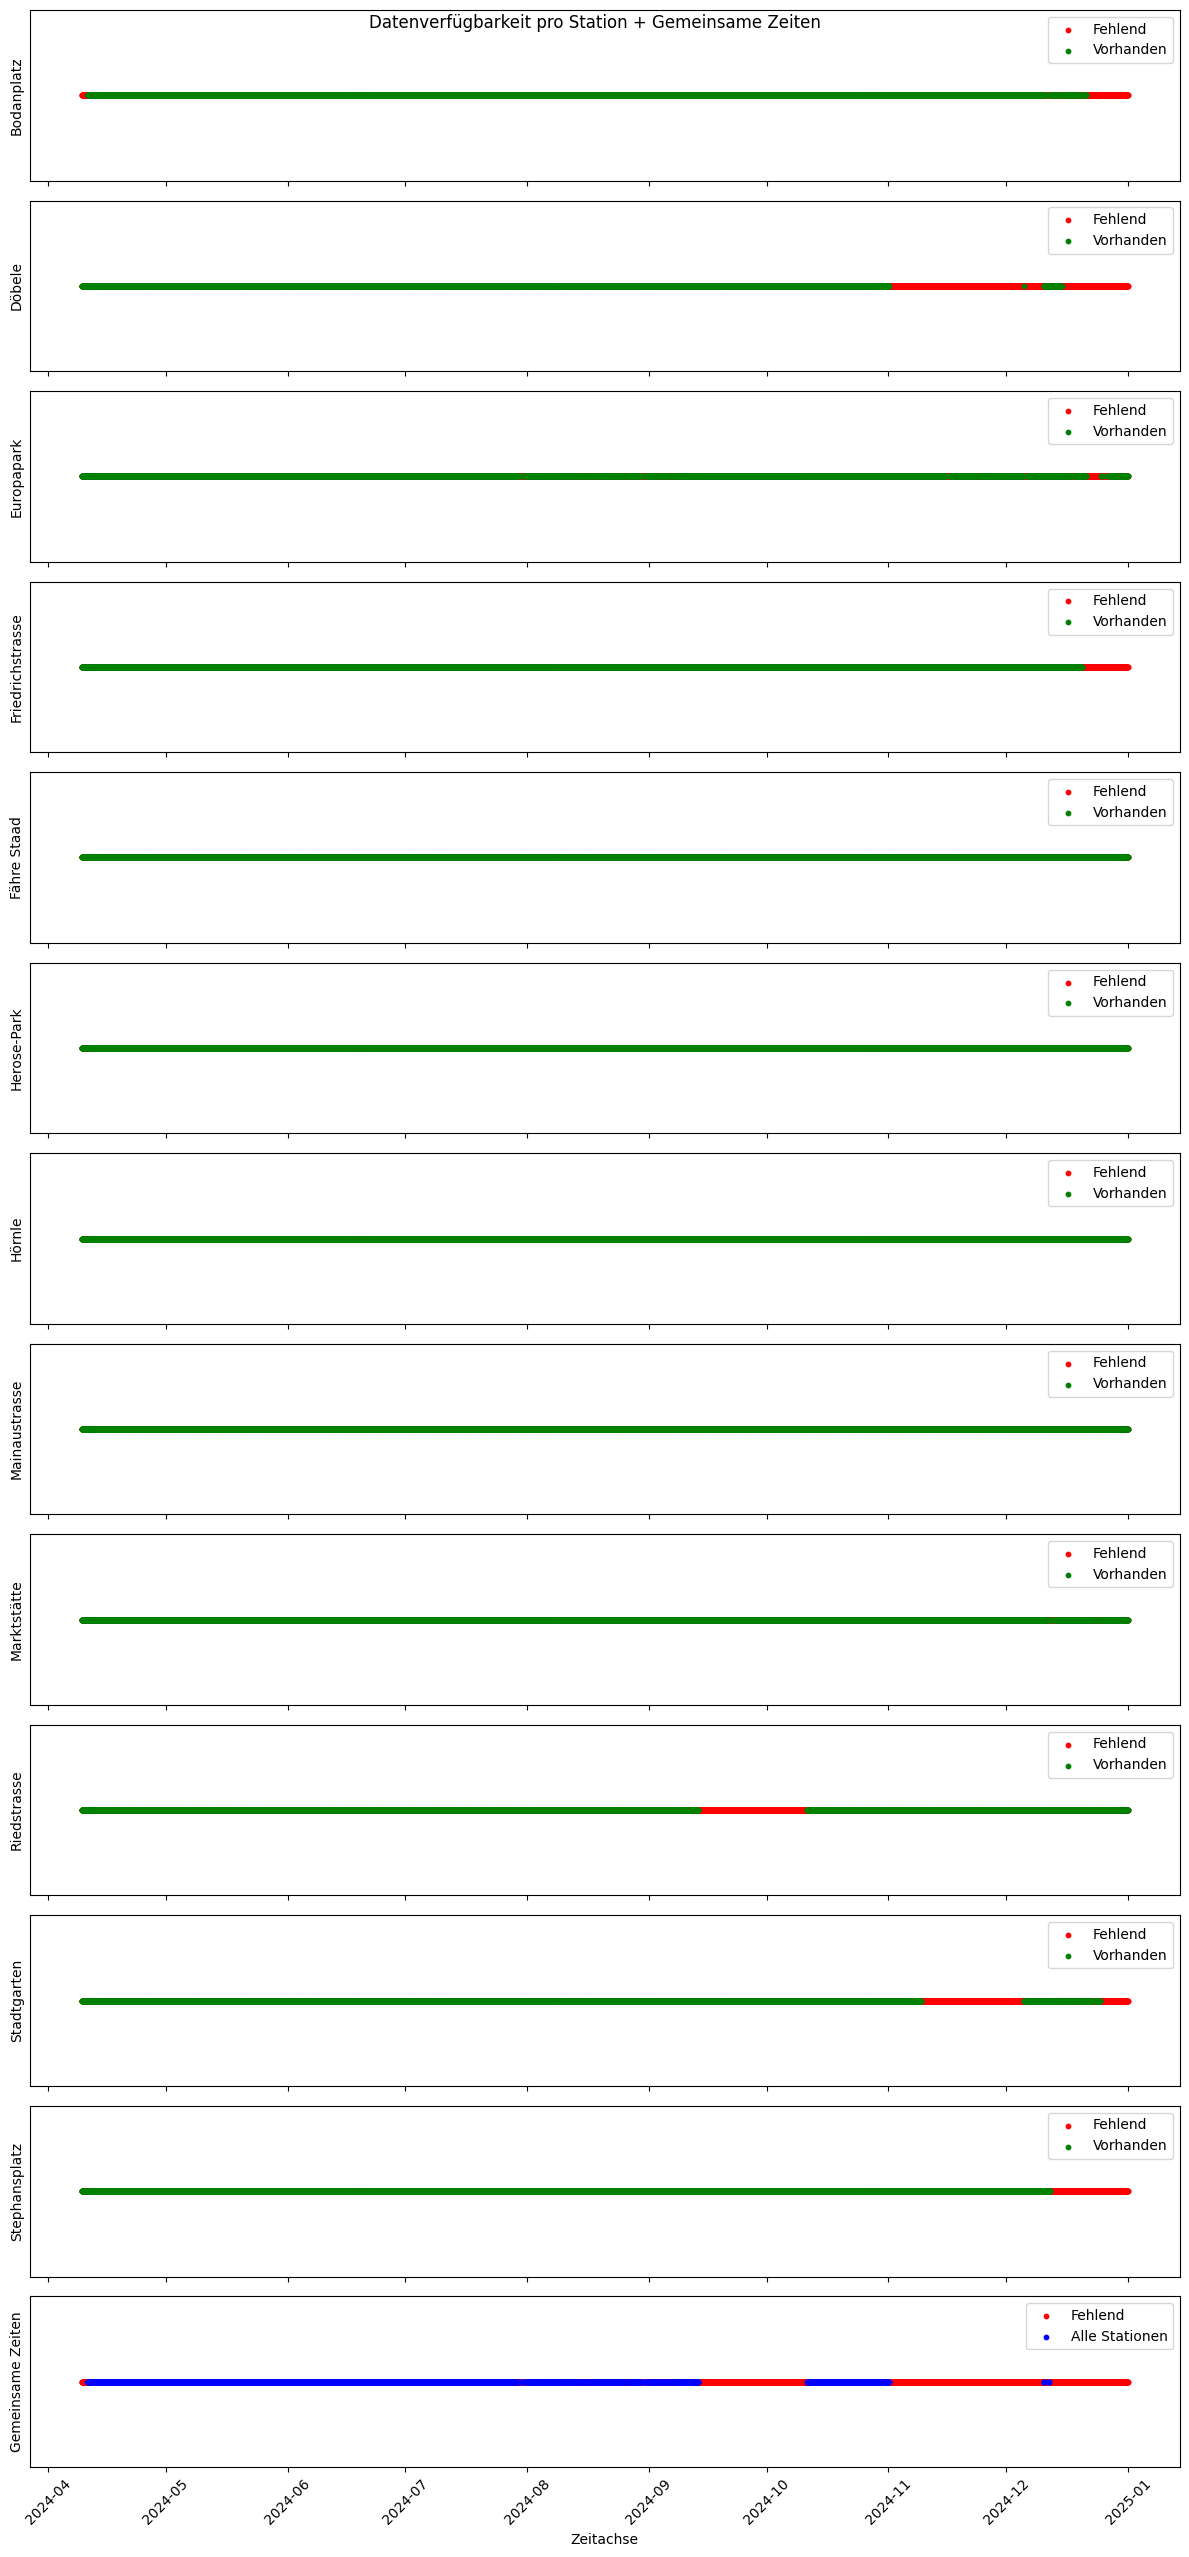

In [42]:
# Figure erstellen
# axes ist eine Liste von Subplots
fig, axes = plt.subplots(num_stations + 1, 1, figsize=(12, 2 * (num_stations + 1)), sharex=True)

# Plot für jede Station: 
# die Punkte für fehlende (rot) und vorhandene (grün) Zeitstempel werden 
# übereinander auf derselben Achse geplottet

for ax, station in zip(axes[:-1], stations):
    #Die Funktion zip() wird hier benutzt, um jeweils eine Achse (ax) mit einer 
    #Station (station) zu kombinieren.
    existing_timestamps = station_timestamps[station]
    missing_timestamps = [ts for ts in full_range if ts not in existing_timestamps]

    ax.scatter(full_range, [1] * len(full_range), color='red', s=10, label="Fehlend")
    ax.scatter(list(existing_timestamps), [1] * len(existing_timestamps), color='green', s=10, label="Vorhanden")

    ax.set_yticks([])  # Y-Achse ausblenden
    ax.set_ylabel(station)  # Stationsnamen als Label
    ax.legend(loc="upper right")

# Letzte Zeile: Gemeinsame Zeiten
ax_common = axes[-1]
ax_common.scatter(full_range, [1] * len(full_range), color='red', s=10, label="Fehlend")
ax_common.scatter(list(common_timestamps), [1] * len(common_timestamps), color='blue', s=10, label="Alle Stationen")


ax_common.set_yticks([])
ax_common.set_ylabel("Gemeinsame Zeiten")
ax_common.legend(loc="upper right")

# X-Achse formatieren
plt.xticks(rotation=45)
axes[-1].set_xlabel("Zeitachse")
plt.suptitle("Datenverfügbarkeit pro Station + Gemeinsame Zeiten")
plt.tight_layout()
plt.show()